In [15]:
from __future__ import division

import bisect
import ctypes
import ctypes.util
import itertools
import datetime
import os
from optparse import OptionParser
import time
import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import spacepy.toolbox as tb
import spacepy.time as spt
import spacepy.datamodel as dm
import spacepy.pycdf as pycdf
import spacepy.plot as spp
import pandas as pd
import seaborn as sns

%matplotlib inline

In [16]:
fname = 'rbspa_ect-hope-sci-L3tagged_20150101_v1.0.0.cdf'

In [17]:
d = dm.fromCDF(fname)

In [18]:
d.tree(verbose=1)

+
|____B_Calc_Ele (spacepy.pycdf.VarCopy (0,))
|____B_Calc_Ion (spacepy.pycdf.VarCopy (0,))
|____B_Eq_Ele (spacepy.pycdf.VarCopy (0,))
|____B_Eq_Ion (spacepy.pycdf.VarCopy (0,))
|____Counts_E (spacepy.pycdf.VarCopy (4143, 5, 16, 72))
|____Counts_H (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
|____Counts_He (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
|____Counts_O (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
|____ENERGY_Ele_DELTA (spacepy.pycdf.VarCopy (4143, 72))
|____ENERGY_Ion_DELTA (spacepy.pycdf.VarCopy (3469, 72))
|____Ele_SAMPLES (spacepy.pycdf.VarCopy (0, 5, 16, 72))
|____Energy_LABL (spacepy.pycdf.VarCopy (72,))
|____Epoch_Ele (spacepy.pycdf.VarCopy (4143,))
|____Epoch_Ele_DELTA (spacepy.pycdf.VarCopy (4143,))
|____Epoch_Ele_Full (spacepy.pycdf.VarCopy (4143, 16, 72))
|____Epoch_Ion (spacepy.pycdf.VarCopy (3469,))
|____Epoch_Ion_DELTA (spacepy.pycdf.VarCopy (3469,))
|____Epoch_Ion_Full (spacepy.pycdf.VarCopy (3469, 16, 72))
|____FEDU (spacepy.pycdf.VarCopy (4143, 5, 16, 72))
|____FHEDU

Text(0.5,0,'pt number')

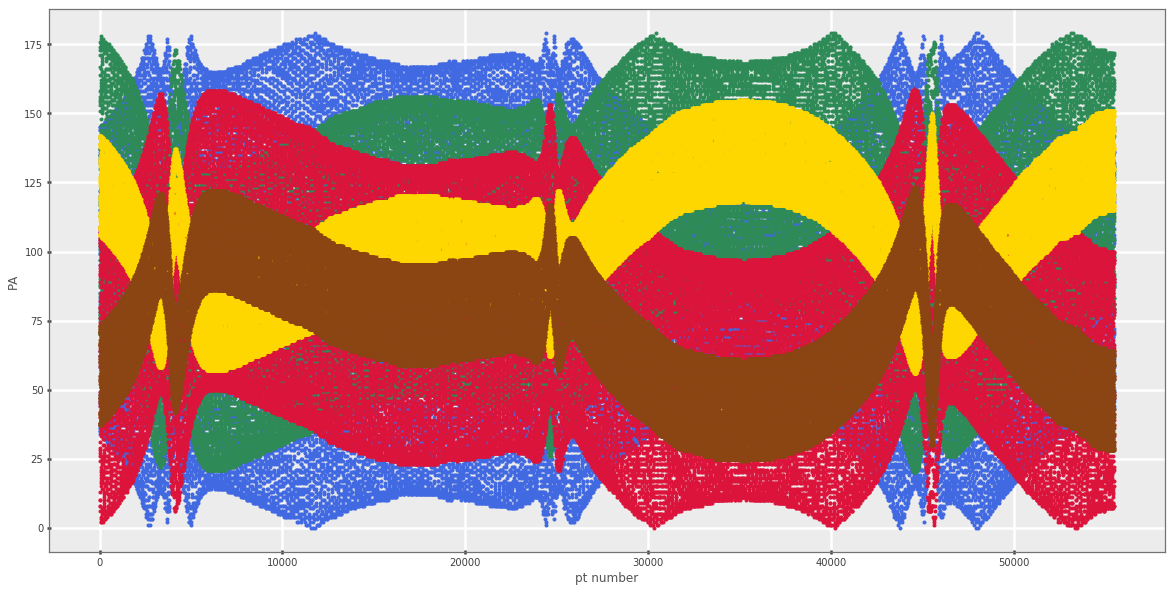

In [19]:
plt.figure(figsize=(20,10))
plt.plot(d['PA_Ion'][:,2,:,50].flatten(),'.')
plt.plot(d['PA_Ion'][:,1,:,50].flatten(),'.')
plt.plot(d['PA_Ion'][:,3,:,50].flatten(),'.')
plt.plot(d['PA_Ion'][:,0,:,50].flatten(),'.')
plt.plot(d['PA_Ion'][:,4,:,50].flatten(),'.')

plt.ylabel('PA')
plt.xlabel('pt number')

# Plot up PA, gryo for some energies over 10 minutes


In [20]:
tbounds = [datetime.datetime(2015, 1, 1, 6), datetime.datetime(2015, 1, 1, 6, 10)]
tind = [bisect.bisect_right(d['Epoch_Ion'], tbounds[0]), 
        bisect.bisect_right(d['Epoch_Ion'], tbounds[1])]
print(tind)


[880, 904]


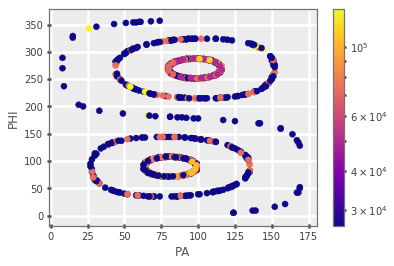

In [21]:
# |____FPDU (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
energy = [50,51]

for pixel in range(5):
    sc = plt.scatter(d['PA_Ion'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten(), 
                    d['PHI_Ion'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten(),
                    c=d['FPDU'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten(), 
                   label='Pixel_{0}'.format(pixel+1), norm=LogNorm())
plt.xlabel('PA')
plt.ylabel('PHI')
plt.colorbar(sc)

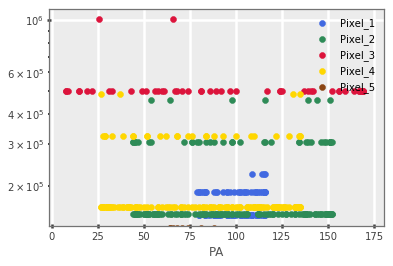

In [22]:
# assume gyrotropy and plot up a line plot by pixel
energy = [50,51]

for pixel in range(5):
    sc = plt.scatter(d['PA_Ion'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten(), 
                    d['FPDU'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten(), 
                   label='Pixel_{0}'.format(pixel+1))
plt.xlabel('PA')
plt.yscale('log')
plt.legend(loc='upper right')

In [23]:
# put in pandas to see if analysis is easier
pixel=0
df = pd.DataFrame.from_dict({'PA':d['PA_Ion'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten(), 
                            'PHI':d['PHI_Ion'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten(),
                            'FPDU':d['FPDU'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten()})
df['FPDU'] /= 8e3 # approximate that this is counts
df['pixel'] = pixel+1

datlen = len(df)
for pixel in range(1,5):
    df2 = pd.DataFrame.from_dict({'PA':d['PA_Ion'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten(), 
                            'PHI':d['PHI_Ion'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten(),
                            'FPDU':d['FPDU'][tind[0]:tind[1], pixel, :, energy[0]:energy[1]].flatten(), 
                   'pixel':np.asarray([pixel+1]*datlen, dtype=np.uint8)})
    df = pd.concat([df, df2], ignore_index=True)
# drop zeros
df = df.loc[df['FPDU'] > 0]
df.iloc[-1]

FPDU     26561.140625
PA          70.000000
PHI         75.000000
pixel        5.000000
Name: 1919, dtype: float64

In [24]:
df['PAbin'] = pd.cut(df['PA'], np.linspace(0,180,18))
df.head()

,FPDU,PA,PHI,pixel,PAbin
0,9.370257,91,252,1,"(84.706, 95.294]"
1,9.370257,98,251,1,"(95.294, 105.882]"
2,9.370257,105,253,1,"(95.294, 105.882]"
3,9.370257,111,257,1,"(105.882, 116.471]"
4,9.370257,114,264,1,"(105.882, 116.471]"


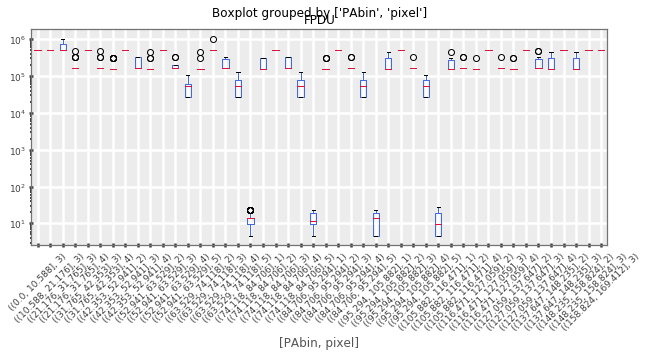

In [25]:
df.boxplot(column='FPDU', by=['PAbin', 'pixel'], figsize=(10,4), fontsize=9, rot=45)
plt.yscale('log')

In [26]:
print(df.groupby('pixel').mean())
print(df.groupby('pixel').std())

                FPDU          PA         PHI
pixel                                       
1          12.421257   98.162791  269.354651
2      198791.234375  101.061728  266.672840
3      522342.687500   92.836735  191.163265
4      200886.890625   83.260274   88.883562
5       59447.804688   80.982143   89.755952
                FPDU         PA         PHI
pixel                                      
1           6.310161  12.738327   12.986507
2       83500.754871  37.012285   41.494268
3      100339.142033  54.571951  112.840290
4       79174.447595  36.974745   41.751070
5       31158.426661  12.734240   13.004246


# Can we just flatten the whole thing and plop in the DF?

In [27]:
# |____Counts_H (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
# |____Epoch_Ion (spacepy.pycdf.VarCopy (3469,))
# |____FPDU (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
# |____HOPE_ENERGY_Ion (spacepy.pycdf.VarCopy (3469, 72))
# |____PA_Ion (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
# |____PHI_Ion (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
initial = True
for pixel, sector, energy in itertools.product(range(5), range(16), [65]):
    dat = {'Counts':d['Counts_H'][:,pixel,sector,energy], 
          'FPDU':d['FPDU'][:,pixel,sector,energy], 
          'PA':d['PA_Ion'][:,pixel,sector,energy], 
          'PHI':d['PHI_Ion'][:,pixel,sector,energy], 
          'Energy':d['HOPE_ENERGY_Ion'][:,energy], 
          'Pixel':pixel,}
    index = d['Epoch_Ion'][:]
    if initial:
        df = pd.DataFrame.from_dict(dat)
        df.index = index
        initial = False
        df['Pixel'] = df['Pixel'].astype('category')
    else:
        df2 = pd.DataFrame.from_dict(dat)
        df2.index = index
        df2['Pixel'] = df2['Pixel'].astype('category')
        df = pd.concat([df, df2])
print(df.shape)
df['PAbin'] = pd.cut(df['PA'], np.linspace(0,180, 18))
df.head()

(277520, 6)


,Counts,Energy,FPDU,PA,PHI,Pixel,PAbin
2015-01-01 00:00:01.562,3.260936,20686.558594,17074.375000,141,260,0,"(137.647, 148.235]"
2015-01-01 00:00:24.259,3.913175,20686.558594,20489.519531,142,272,0,"(137.647, 148.235]"
2015-01-01 00:00:46.955,4.565431,20686.558594,23904.751953,139,284,0,"(137.647, 148.235]"
2015-01-01 00:01:09.652,4.565431,20686.558594,23904.751953,132,290,0,"(127.059, 137.647]"
2015-01-01 00:01:32.349,5.869993,20686.558594,30735.484375,124,291,0,"(116.471, 127.059]"


In [28]:
np.unique(df['Pixel'])

array([0, 1, 2, 3, 4])

In [29]:
df['Counts'].loc[df['Counts']>0].min()

0.46215799

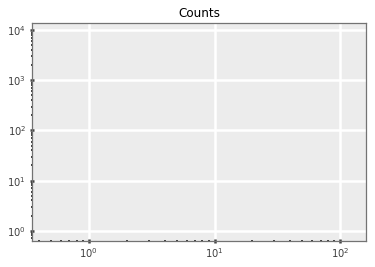

In [30]:
ax = plt.gca()
for pixel in range(1,6):
    df.loc[df['Pixel']==pixel].hist('Counts', ax=ax, 
                                    bins=tb.logspace(df['Counts'].loc[df['Counts']>0].min(), 
                                                    df['Counts'].loc[df['Counts']>0].max(), 
                                                    20))
plt.xscale('log')
plt.yscale('log')

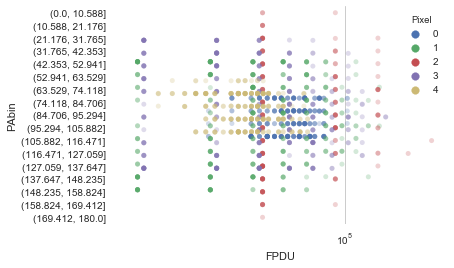

In [31]:
tmask = (df.index >= tbounds[0]) & (df.index < tbounds[1])

sns.set(style="whitegrid")

# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="FPDU", y="PAbin", hue="Pixel",
              data=df[tmask], dodge=True, jitter=0.1,
              alpha=.25, zorder=1)

plt.xscale('log')

# # Show the conditional means
# sns.pointplot(x="value", y="measurement", hue="species",
#               data=iris, dodge=.532, join=False, palette="dark",
#               markers="d", scale=.75, ci=None)



In [32]:

df10m1 = df.loc[df['Pixel']==0].resample(datetime.timedelta(minutes=10)).apply(np.mean)
df10m2 = df.loc[df['Pixel']==1].resample(datetime.timedelta(minutes=10)).apply(np.mean)
df10m3 = df.loc[df['Pixel']==2].resample(datetime.timedelta(minutes=10)).apply(np.mean)
df10m4 = df.loc[df['Pixel']==3].resample(datetime.timedelta(minutes=10)).apply(np.mean)
df10m5 = df.loc[df['Pixel']==4].resample(datetime.timedelta(minutes=10)).apply(np.mean)

df10m = pd.concat([df10m1, df10m2, df10m3, df10m4, df10m5])
df10m['PAbin'] = pd.cut(df10m['PA'], np.arange(0,181, 10))

print(np.unique(df10m['Pixel']))
df10m.head()

[0 1 2 3 4]


,Counts,Energy,FPDU,PA,PHI,Pixel,PAbin
2015-01-01 00:00:00,3.150134,20686.558594,16494.210938,121.887500,269.525000,0,"(120, 130]"
2015-01-01 00:10:00,0.903525,20686.558594,4730.887207,119.166667,269.520833,0,"(110, 120]"
2015-01-01 00:20:00,0.313035,20686.558594,1639.062256,116.015000,269.492500,0,"(110, 120]"
2015-01-01 00:30:00,0.101899,20686.558594,533.546265,112.276042,269.486979,0,"(110, 120]"
2015-01-01 00:40:00,0.019565,20686.558594,102.440887,107.647500,269.487500,0,"(100, 110]"


In [33]:
df10m.index[0]


Timestamp('2015-01-01 00:00:00')

In [34]:
df10m.loc[df10m.index == df10m.index[0]]

,Counts,Energy,FPDU,PA,PHI,Pixel,PAbin
2015-01-01,3.150134,20686.558594,16494.210938,121.8875,269.5250,0,"(120, 130]"
2015-01-01,2.655807,20686.558594,13905.898438,113.1100,269.4800,1,"(110, 120]"
2015-01-01,2.073921,20686.558594,10859.122070,89.5350,180.3275,2,"(80, 90]"
2015-01-01,2.283880,20686.558594,11958.475586,65.9825,89.1700,3,"(60, 70]"
2015-01-01,1.996675,20686.558594,10454.661133,57.1900,89.4725,4,"(50, 60]"


# Split up into a few PA, gyro bins and see about matching up

In [35]:
PA_bins = np.linspace(0, 180, 8)
print(PA_bins)
PHI_bins = np.linspace(0, 360, 5)
print(PHI_bins)

[   0.           25.71428571   51.42857143   77.14285714  102.85714286
  128.57142857  154.28571429  180.        ]
[   0.   90.  180.  270.  360.]


In [36]:
PA_digs0 = np.digitize(d['PA_Ion'][:, 0, :, 70], PA_bins)
print(PA_digs0.shape, PA_digs0.min(), PA_digs0.max(), len(PA_bins))
PA_digs1 = np.digitize(d['PA_Ion'][:, 1, :, 70], PA_bins)
print(PA_digs1.shape, PA_digs1.min(), PA_digs1.max(), len(PA_bins))
PA_digs2 = np.digitize(d['PA_Ion'][:, 2, :, 70], PA_bins)
print(PA_digs2.shape, PA_digs2.min(), PA_digs2.max(), len(PA_bins))
PA_digs3 = np.digitize(d['PA_Ion'][:, 3, :, 70], PA_bins)
print(PA_digs3.shape, PA_digs3.min(), PA_digs3.max(), len(PA_bins))
PA_digs4 = np.digitize(d['PA_Ion'][:, 4, :, 70], PA_bins)
print(PA_digs4.shape, PA_digs4.min(), PA_digs4.max(), len(PA_bins))

PHI_digs0 = np.digitize(d['PHI_Ion'][:, 0, :, 70], PHI_bins)
print(PHI_digs0.shape, PHI_digs0.min(), PHI_digs0.max(), len(PHI_bins))
PHI_digs1 = np.digitize(d['PHI_Ion'][:, 1, :, 70], PHI_bins)
print(PHI_digs1.shape, PHI_digs1.min(), PHI_digs1.max(), len(PHI_bins))
PHI_digs2 = np.digitize(d['PHI_Ion'][:, 2, :, 70], PHI_bins)
print(PHI_digs2.shape, PHI_digs2.min(), PHI_digs2.max(), len(PHI_bins))
PHI_digs3 = np.digitize(d['PHI_Ion'][:, 3, :, 70], PHI_bins)
print(PHI_digs3.shape, PHI_digs3.min(), PHI_digs3.max(), len(PHI_bins))
PHI_digs4 = np.digitize(d['PHI_Ion'][:, 4, :, 70], PHI_bins)
print(PHI_digs4.shape, PHI_digs4.min(), PHI_digs4.max(), len(PHI_bins))


(3469, 16) 3 7 8
(3469, 16) 1 7 8
(3469, 16) 1 7 8
(3469, 16) 1 7 8
(3469, 16) 1 5 8
(3469, 16) 3 4 5
(3469, 16) 1 4 5
(3469, 16) 1 4 5
(3469, 16) 1 4 5
(3469, 16) 1 2 5


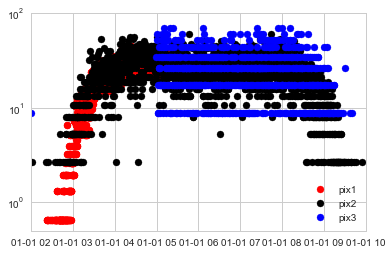

In [37]:
# split out the counts data for a particular bin
PA_digs0.shape, d['Counts_H'][:,0,:,70].shape

bdat0 = d['Counts_H'][:,0,:,70][(PA_digs0==3) & (PHI_digs0==3)]
bdat1 = d['Counts_H'][:,1,:,70][(PA_digs1==3) & (PHI_digs1==3)]
bdat2 = d['Counts_H'][:,2,:,70][(PA_digs2==3) & (PHI_digs2==3)]
bdat3 = d['Counts_H'][:,3,:,70][(PA_digs3==3) & (PHI_digs3==3)]
bdat4 = d['Counts_H'][:,4,:,70][(PA_digs4==3) & (PHI_digs4==3)]
tt0 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs0==3) & (PHI_digs0==3)], 'CDF')
tt1 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs1==3) & (PHI_digs1==3)], 'CDF')
tt2 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs2==3) & (PHI_digs2==3)], 'CDF')
# tt3 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs3==3) & (PHI_digs3==3)], 'CDF')
# tt4 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs4==3) & (PHI_digs4==3)], 'CDF')


# plt.semilogy(tt0.UTC, bdat0)
# plt.semilogy(tt1.UTC, bdat1)
# plt.semilogy(tt2.UTC, bdat2)
# plt.semilogy(tt3.UTC, bdat3)
# plt.semilogy(tt4.UTC, bdat4)


plt.scatter(tt0.UTC, bdat0, c='r', label='pix1')
plt.scatter(tt1.UTC, bdat1, c='k', label='pix2')
plt.scatter(tt2.UTC, bdat2, c='b', label='pix3')
# plt.semilogy(tt3.UTC, bdat3)
# plt.semilogy(tt4.UTC, bdat4)

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,10)))
plt.ylim((1/2, 100))

plt.legend()


## smooth in time

(2, 252)
(2, 283)
(2, 288)
(2, 252)
(2, 283)
(2, 288)


/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in float_scalars


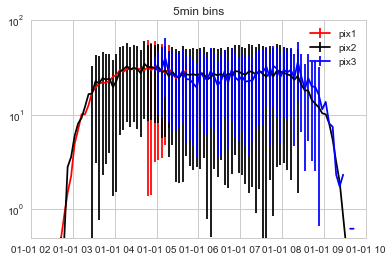

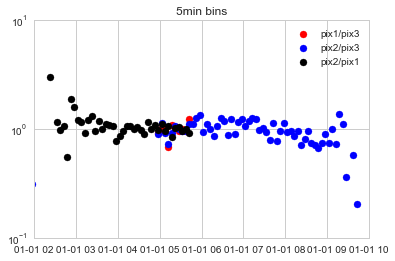

In [38]:
# split out the counts data for a particular bin
PA_digs0.shape, d['Counts_H'][:,0,:,70].shape

bdat0 = d['Counts_H'][:,0,:,70][(PA_digs0==3) & (PHI_digs0==3)]
bdat1 = d['Counts_H'][:,1,:,70][(PA_digs1==3) & (PHI_digs1==3)]
bdat2 = d['Counts_H'][:,2,:,70][(PA_digs2==3) & (PHI_digs2==3)]
bdat3 = d['Counts_H'][:,3,:,70][(PA_digs3==3) & (PHI_digs3==3)]
bdat4 = d['Counts_H'][:,4,:,70][(PA_digs4==3) & (PHI_digs4==3)]
tt0 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs0==3) & (PHI_digs0==3)], 'CDF')
tt1 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs1==3) & (PHI_digs1==3)], 'CDF')
tt2 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs2==3) & (PHI_digs2==3)], 'CDF')
# tt3 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs3==3) & (PHI_digs3==3)], 'CDF')
# tt4 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs4==3) & (PHI_digs4==3)], 'CDF')

# tb.windowMean(data, time=[], winsize=0, overlap=0, st_time=None, op=<function mean at 0x1094d7488>)

st_time=datetime.datetime(2015,1,1)
tdel = datetime.timedelta(minutes=5)

wm0 = np.asarray(tb.windowMean(bdat0, time=tt0.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm0.shape)
wm1 = np.asarray(tb.windowMean(bdat1, time=tt1.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm1.shape)
wm2 = np.asarray(tb.windowMean(bdat2, time=tt2.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm2.shape)

wms0 = np.asarray(tb.windowMean(bdat0, time=tt0.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm0.shape)
wms1 = np.asarray(tb.windowMean(bdat1, time=tt1.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm1.shape)
wms2 = np.asarray(tb.windowMean(bdat2, time=tt2.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm2.shape)

# plt.scatter(wm0[1], wm0[0], c='r', label='pix1')
# plt.scatter(wm1[1], wm1[0], c='k', label='pix2')
# plt.scatter(wm2[1], wm2[0], c='b', label='pix3')
plt.errorbar(wm0[1], wm0[0], np.sqrt(wms0[0].astype(float)), c='r', label='pix1')
plt.errorbar(wm1[1], wm1[0], np.sqrt(wms1[0].astype(float)), c='k', label='pix2')
plt.errorbar(wm2[1], wm2[0], np.sqrt(wms2[0].astype(float)), c='b', label='pix3')


# plt.semilogy(tt3.UTC, bdat3)
# plt.semilogy(tt4.UTC, bdat4)

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,10)))
plt.ylim((1/2, 100))
plt.title('5min bins')
plt.legend()


# to do ratios we have to trim the end time to the region of interest
e_time = datetime.datetime(2015,1,1,10)
ind0 = wm0[1] <= e_time
ind1 = wm1[1] <= e_time
ind2 = wm2[1] <= e_time


plt.figure()
plt.scatter(wm0[1][ind0], wm0[0][ind0]/wm2[0][ind2], 
            c='r', label='pix1/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm2[0][ind2], 
            c='b', label='pix2/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm0[0][ind0], 
            c='k', label='pix2/pix1')

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,10)))
plt.ylim((.1, 10))
plt.title('5min bins')

plt.legend()



(2, 252)
(2, 283)
(2, 288)
(2, 252)
(2, 283)
(2, 288)
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  na

/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in float_scalars


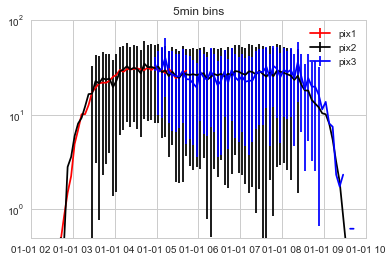

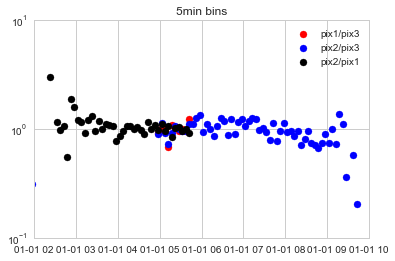

In [39]:
err = dm.fromHDF5('../Poisson.h5')

# split out the counts data for a particular bin
PA_digs0.shape, d['Counts_H'][:,0,:,70].shape

bdat0 = d['Counts_H'][:,0,:,70][(PA_digs0==3) & (PHI_digs0==3)]
bdat1 = d['Counts_H'][:,1,:,70][(PA_digs1==3) & (PHI_digs1==3)]
bdat2 = d['Counts_H'][:,2,:,70][(PA_digs2==3) & (PHI_digs2==3)]
bdat3 = d['Counts_H'][:,3,:,70][(PA_digs3==3) & (PHI_digs3==3)]
bdat4 = d['Counts_H'][:,4,:,70][(PA_digs4==3) & (PHI_digs4==3)]
tt0 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs0==3) & (PHI_digs0==3)], 'CDF')
tt1 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs1==3) & (PHI_digs1==3)], 'CDF')
tt2 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs2==3) & (PHI_digs2==3)], 'CDF')
# tt3 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs3==3) & (PHI_digs3==3)], 'CDF')
# tt4 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs4==3) & (PHI_digs4==3)], 'CDF')

# tb.windowMean(data, time=[], winsize=0, overlap=0, st_time=None, op=<function mean at 0x1094d7488>)

st_time=datetime.datetime(2015,1,1)
tdel = datetime.timedelta(minutes=5)

wm0 = np.asarray(tb.windowMean(bdat0, time=tt0.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm0.shape)
wm1 = np.asarray(tb.windowMean(bdat1, time=tt1.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm1.shape)
wm2 = np.asarray(tb.windowMean(bdat2, time=tt2.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm2.shape)

wms0 = np.asarray(tb.windowMean(bdat0, time=tt0.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm0.shape)
wms1 = np.asarray(tb.windowMean(bdat1, time=tt1.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm1.shape)
wms2 = np.asarray(tb.windowMean(bdat2, time=tt2.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm2.shape)

# plt.scatter(wm0[1], wm0[0], c='r', label='pix1')
# plt.scatter(wm1[1], wm1[0], c='k', label='pix2')
# plt.scatter(wm2[1], wm2[0], c='b', label='pix3')

err0 = []
for i in wms0[0]:
    try:
        err0.append(err['value'][i][3,5])
    except (KeyError, IndexError):
        err0.append(np.nan)
err0 = np.asarray(err0)
print(err0, err0.shape)
        
plt.errorbar(wm0[1], wm0[0], err0, c='r', label='pix1')
plt.errorbar(wm1[1], wm1[0], np.sqrt(wms1[0].astype(float)), c='k', label='pix2')
plt.errorbar(wm2[1], wm2[0], np.sqrt(wms2[0].astype(float)), c='b', label='pix3')


# plt.semilogy(tt3.UTC, bdat3)
# plt.semilogy(tt4.UTC, bdat4)

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,10)))
plt.ylim((1/2, 100))
plt.title('5min bins')
plt.legend()


# to do ratios we have to trim the end time to the region of interest
e_time = datetime.datetime(2015,1,1,10)
ind0 = wm0[1] <= e_time
ind1 = wm1[1] <= e_time
ind2 = wm2[1] <= e_time


plt.figure()
plt.scatter(wm0[1][ind0], wm0[0][ind0]/wm2[0][ind2], 
            c='r', label='pix1/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm2[0][ind2], 
            c='b', label='pix2/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm0[0][ind0], 
            c='k', label='pix2/pix1')

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,10)))
plt.ylim((.1, 10))
plt.title('5min bins')

plt.legend()



(2, 42)
(2, 48)
(2, 48)


/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in float_scalars
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in float_scalars


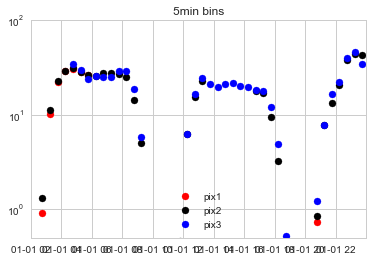

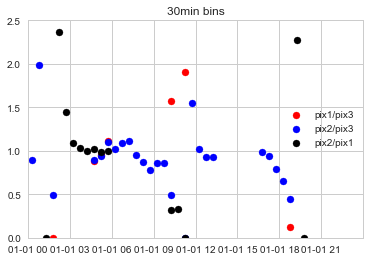

In [41]:
# split out the counts data for a particular bin
PA_digs0.shape, d['Counts_H'][:,0,:,70].shape

bdat0 = d['Counts_H'][:,0,:,70][(PA_digs0==3) & (PHI_digs0==3)]
bdat1 = d['Counts_H'][:,1,:,70][(PA_digs1==3) & (PHI_digs1==3)]
bdat2 = d['Counts_H'][:,2,:,70][(PA_digs2==3) & (PHI_digs2==3)]
bdat3 = d['Counts_H'][:,3,:,70][(PA_digs3==3) & (PHI_digs3==3)]
bdat4 = d['Counts_H'][:,4,:,70][(PA_digs4==3) & (PHI_digs4==3)]
tt0 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs0==3) & (PHI_digs0==3)], 'CDF')
tt1 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs1==3) & (PHI_digs1==3)], 'CDF')
tt2 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs2==3) & (PHI_digs2==3)], 'CDF')
# tt3 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs3==3) & (PHI_digs3==3)], 'CDF')
# tt4 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs4==3) & (PHI_digs4==3)], 'CDF')

# tb.windowMean(data, time=[], winsize=0, overlap=0, st_time=None, op=<function mean at 0x1094d7488>)

st_time=datetime.datetime(2015,1,1)
tdel = datetime.timedelta(minutes=30)

wm0 = np.asarray(tb.windowMean(bdat0, time=tt0.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm0.shape)
wm1 = np.asarray(tb.windowMean(bdat1, time=tt1.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm1.shape)
wm2 = np.asarray(tb.windowMean(bdat2, time=tt2.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm2.shape)

plt.scatter(wm0[1], wm0[0], c='r', label='pix1')
plt.scatter(wm1[1], wm1[0], c='k', label='pix2')
plt.scatter(wm2[1], wm2[0], c='b', label='pix3')
# plt.semilogy(tt3.UTC, bdat3)
# plt.semilogy(tt4.UTC, bdat4)

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,23,59)))
plt.ylim((1/2, 100))
plt.title('5min bins')
plt.legend()


# to do ratios we have to trim the end time to the region of interest
e_time = datetime.datetime(2015,1,1,20)
ind0 = wm0[1] <= e_time
ind1 = wm1[1] <= e_time
ind2 = wm2[1] <= e_time


plt.figure()
plt.scatter(wm0[1][ind0], wm0[0][ind0]/wm2[0][ind2], 
            c='r', label='pix1/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm2[0][ind2], 
            c='b', label='pix2/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm0[0][ind0], 
            c='k', label='pix2/pix1')

plt.yscale('linear')
plt.xlim((datetime.datetime(2015,1,1,0), 
          datetime.datetime(2015,1,1,23,59)))
plt.ylim((0, 2.5))
plt.title('30min bins')

plt.legend()



# Go back to the DF (2017-12-24)

In [44]:
df.head()

,Counts,Energy,FPDU,PA,PHI,Pixel,PAbin
2015-01-01 00:00:01.562,3.260936,20686.558594,17074.375000,141,260,0,"(137.647, 148.235]"
2015-01-01 00:00:24.259,3.913175,20686.558594,20489.519531,142,272,0,"(137.647, 148.235]"
2015-01-01 00:00:46.955,4.565431,20686.558594,23904.751953,139,284,0,"(137.647, 148.235]"
2015-01-01 00:01:09.652,4.565431,20686.558594,23904.751953,132,290,0,"(127.059, 137.647]"
2015-01-01 00:01:32.349,5.869993,20686.558594,30735.484375,124,291,0,"(116.471, 127.059]"


## Plot up pixels 2, 3, 4 and look for the overlap

In [46]:
# let's make the pixels match the way to talk
df['Pixel'] += 1

array([ 20686.55859375,  27153.33984375], dtype=float32)

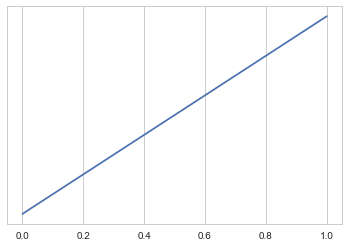

In [50]:
energies = np.unique(df.loc[df['Pixel']==3]['Energy'])
plt.semilogy(energies)
energies